In [1]:
import os

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

FTRAIN = 'data/training.csv'
FTEST = 'data/test.csv'

In [2]:
def load(test=False, cols=None):
    """testがTrueの場合はFTESTからデータを読み込み、Falseの場合はFTRAINから読み込みます。
    colsにリストが渡された場合にはそのカラムに関するデータのみ返します。
    """

    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname)) # pandasのdataframeを使用

    # スペースで句切られているピクセル値をnumpy arrayに変換
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # カラムに関連するデータのみを抽出
        df = df[list(cols) + ['Image']]

    print(df.count())  # カラム毎に値が存在する行数を出力
    df = df.dropna()  # データが欠けている行は捨てる

    X = np.vstack(df['Image'].values) / 255.  # 0から1の値に変換
    X = X.astype(np.float32)

    if not test:  # ラベルが存在するのはFTRAINのみ
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # -1から1の値に変換
        X, y = shuffle(X, y, random_state=42)  # データをシャッフル
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

In [15]:
X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(100, input_dim=9216))
model.add(Activation('relu'))
model.add(Dense(30))

Using TensorFlow backend.


In [5]:
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)
hist = model.fit(X, y, epochs=100, validation_split=0.2)

Train on 1712 samples, validate on 428 samples
Epoch 1/100
1712/1712 [==============================] - 2s - loss: 0.0504 - val_loss: 0.0134
Epoch 2/100
1712/1712 [==============================] - 0s - loss: 0.0118 - val_loss: 0.0116
Epoch 3/100
1712/1712 [==============================] - 0s - loss: 0.0104 - val_loss: 0.0104
Epoch 4/100
1712/1712 [==============================] - 0s - loss: 0.0093 - val_loss: 0.0102
Epoch 5/100
1712/1712 [==============================] - 0s - loss: 0.0089 - val_loss: 0.0107
Epoch 6/100
1712/1712 [==============================] - 0s - loss: 0.0083 - val_loss: 0.0090
Epoch 7/100
1712/1712 [==============================] - 0s - loss: 0.0079 - val_loss: 0.0089
Epoch 8/100
1712/1712 [==============================] - 0s - loss: 0.0077 - val_loss: 0.0079
Epoch 9/100
1712/1712 [==============================] - 0s - loss: 0.0073 - val_loss: 0.0077
Epoch 10/100
1712/1712 [==============================] - 0s - loss: 0.0071 - val_loss: 0.0077
Epoch 11/100

In [6]:
import matplotlib.pyplot as plt

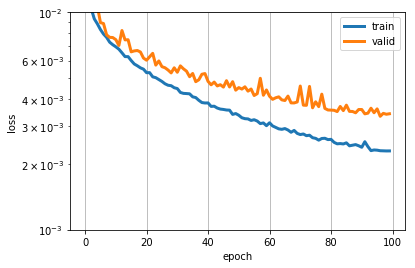

In [7]:
plt.plot(hist.history['loss'], linewidth=3, label='train')
plt.plot(hist.history['val_loss'], linewidth=3, label='valid')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(1e-3, 1e-2)
plt.yscale('log')
plt.show()

In [8]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

ImageId    1783
Image      1783
dtype: int64


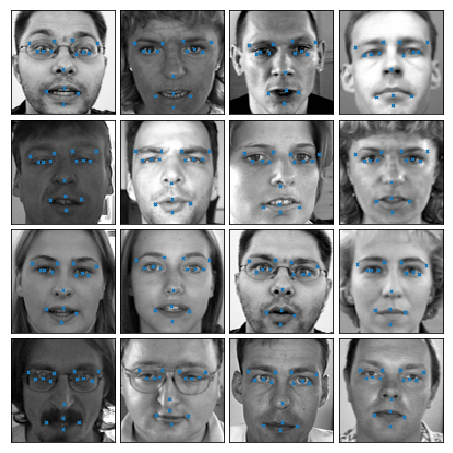

In [9]:
X_test, _ = load(test=True)
y_test = model.predict(X_test)

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_test[i], axis)

plt.show()

In [10]:
json_string = model.to_json()
open('model1_architecture.json', 'w').write(json_string)
model.save_weights('model1_weights.h5')

In [29]:
def load2d(test=False, cols=None):
    X, y = load(test, cols)
    X = X.reshape(-1, 96, 96, 1)
    return X, y

In [30]:
from keras.layers import Convolution2D, MaxPooling2D, Flatten

X, y = load2d()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [13]:
from keras.layers import Conv2D, MaxPooling2D

In [21]:
model2 = Sequential()

model2.add(Convolution2D(32, 3, 3, input_shape=(96, 96, 1)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Convolution2D(64, 2, 2))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Convolution2D(128, 2, 2))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(500))
model2.add(Activation('relu'))
model2.add(Dense(500))
model2.add(Activation('relu'))
model2.add(Dense(30))

C:\Users\Terada\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(96, 96, 1...)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Terada\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (2, 2))`
  import sys
C:\Users\Terada\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (2, 2))`
  # This is added back by InteractiveShellApp.init_path()


As you understood already, your issue comes from the image_ordering_dim. Keras maps the convolution operation to the chosen backend (theano or tensorflow). However, both backends have made different choices for the ordering of the dimensions. If your image batch is of N images of HxW size with C channels, theano uses the NCHW ordering while tensorflow uses the NHWC ordering.

Keras allows you to choose which ordering you prefer and will do the conversion to map to the backends behind. But if you choose image_ordering_dim="th" it expects Theano-style ordering (NCHW, the one you have in your code) and if image_ordering_dim="tf" it expects tensorflow-style ordering (NHWC).

I'd expect if you change to

X_train = X_train.reshape(X_train.shape[0], img_cols, img_rows, 1)
X_test = X_test.reshape(X_test.shape[0], img_cols, img_rows, 1)
and

input_shape=(img_cols, img_rows, 1)

In [31]:
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model2.compile(loss='mean_squared_error', optimizer=sgd)
hist2 = model2.fit(X, y, epochs=100, validation_split=0.2)

Train on 1712 samples, validate on 428 samples
Epoch 1/100
1712/1712 [==============================] - 2s - loss: 0.0400 - val_loss: 0.0066
Epoch 2/100
1712/1712 [==============================] - 0s - loss: 0.0065 - val_loss: 0.0059
Epoch 3/100
1712/1712 [==============================] - 0s - loss: 0.0058 - val_loss: 0.0053
Epoch 4/100
1712/1712 [==============================] - 0s - loss: 0.0054 - val_loss: 0.0050
Epoch 5/100
1712/1712 [==============================] - 0s - loss: 0.0051 - val_loss: 0.0048
Epoch 6/100
1712/1712 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0047
Epoch 7/100
1712/1712 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0046
Epoch 8/100
1712/1712 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0045
Epoch 9/100
1712/1712 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0045
Epoch 10/100
1712/1712 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0044
Epoch 11/100

In [23]:
#from keras.utils.visualize_util import plot
#plot(model2, to_file='model2.png', show_shapes=True)

ImageId    1783
Image      1783
dtype: int64
ImageId    1783
Image      1783
dtype: int64


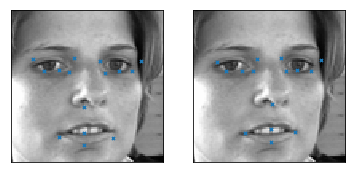

In [33]:
sample1 = load(test=True)[0][6:7]
sample2 = load2d(test=True)[0][6:7]
y_pred1 = model.predict(sample1)[0]
y_pred2 = model2.predict(sample2)[0]

fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_sample(sample1, y_pred1, ax)
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_sample(sample2, y_pred2, ax)
plt.show()

In [36]:
X, y = load2d()
X_flipped = X[:, :, ::-1, :]

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

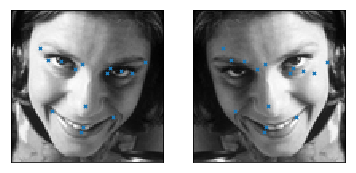

In [37]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_sample(X[1], y[1], ax)
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_sample(X_flipped[1], y[1], ax)
plt.show()

In [38]:
flip_indices = [
    (0, 2), (1, 3),
    (4, 8), (5, 9), (6, 10), (7, 11),
    (12, 16), (13, 17), (14, 18), (15, 19),
    (22, 24), (23, 25),
    ]

df = read_csv(os.path.expanduser(FTRAIN))
for i, j in flip_indices:
    print("{} -> {}".format(df.columns[i], df.columns[j]))

left_eye_center_x -> right_eye_center_x
left_eye_center_y -> right_eye_center_y
left_eye_inner_corner_x -> right_eye_inner_corner_x
left_eye_inner_corner_y -> right_eye_inner_corner_y
left_eye_outer_corner_x -> right_eye_outer_corner_x
left_eye_outer_corner_y -> right_eye_outer_corner_y
left_eyebrow_inner_end_x -> right_eyebrow_inner_end_x
left_eyebrow_inner_end_y -> right_eyebrow_inner_end_y
left_eyebrow_outer_end_x -> right_eyebrow_outer_end_x
left_eyebrow_outer_end_y -> right_eyebrow_outer_end_y
mouth_left_corner_x -> mouth_right_corner_x
mouth_left_corner_y -> mouth_right_corner_y


In [45]:
from keras.preprocessing.image import ImageDataGenerator
class FlippedImageDataGenerator(ImageDataGenerator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def next(self):
        X_batch, y_batch = super(FlippedImageDataGenerator, self).next()
        batch_size = X_batch.shape[0]
        indices = np.random.choice(batch_size, batch_size/2, replace=False)
        X_batch[indices] = X_batch[indices, :, :, ::-1]

        if y_batch is not None:
            # x座標をフリップ
            y_batch[indices, ::2] = y_batch[indices, ::2] * -1

            # left_eye_center_x -> right_eye_center_x のようにフリップ
            for a, b in self.flip_indices:
                y_batch[indices, a], y_batch[indices, b] = (
                    y_batch[indices, b], y_batch[indices, a]
                )

        return X_batch, y_batch

In [46]:
from sklearn.cross_validation import train_test_split

X, y = load2d()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\Terada\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [47]:
model3 = Sequential()

model3.add(Convolution2D(32, 3, 3, input_shape=(96, 96, 1)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Convolution2D(64, 2, 2))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Convolution2D(128, 2, 2))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())
model3.add(Dense(500))
model3.add(Activation('relu'))
model3.add(Dense(500))
model3.add(Activation('relu'))
model3.add(Dense(30))

C:\Users\Terada\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(96, 96, 1...)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Terada\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (2, 2))`
  import sys
C:\Users\Terada\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (2, 2))`
  # This is added back by InteractiveShellApp.init_path()


In [49]:
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model3.compile(loss='mean_squared_error', optimizer=sgd)
flipgen = FlippedImageDataGenerator()
hist3 = model3.fit_generator(flipgen.flow(X_train, y_train),
                             samples_per_epoch=X_train.shape[0],
                             nb_epoch=3000,
                             validation_data=(X_val, y_val))

C:\Users\Terada\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
C:\Users\Terada\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=(array([[[..., steps_per_epoch=53, epochs=3000)`
  import sys


Epoch 1/3000
53/53 [==============================] - 2s - loss: 0.0294 - val_loss: 0.0077
Epoch 2/3000
53/53 [==============================] - 0s - loss: 0.0070 - val_loss: 0.0064
Epoch 3/3000
53/53 [==============================] - 0s - loss: 0.0061 - val_loss: 0.0057
Epoch 4/3000
53/53 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0052
Epoch 5/3000
53/53 [==============================] - 0s - loss: 0.0051 - val_loss: 0.0049
Epoch 6/3000
53/53 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0046
Epoch 7/3000
53/53 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0045
Epoch 8/3000
53/53 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0044
Epoch 9/3000
53/53 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0043
Epoch 10/3000
53/53 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0043
Epoch 11/3000
53/53 [==============================] - 0s - loss: 0.0044 - val_loss: 0.00

53/53 [==============================] - 0s - loss: 0.0026 - val_loss: 0.0026
Epoch 91/3000
53/53 [==============================] - 0s - loss: 0.0026 - val_loss: 0.0026
Epoch 92/3000
53/53 [==============================] - 0s - loss: 0.0027 - val_loss: 0.0026
Epoch 93/3000
53/53 [==============================] - 0s - loss: 0.0025 - val_loss: 0.0026
Epoch 94/3000
53/53 [==============================] - 0s - loss: 0.0025 - val_loss: 0.0025
Epoch 95/3000
53/53 [==============================] - 0s - loss: 0.0026 - val_loss: 0.0025
Epoch 96/3000
53/53 [==============================] - 0s - loss: 0.0025 - val_loss: 0.0025
Epoch 97/3000
53/53 [==============================] - 0s - loss: 0.0025 - val_loss: 0.0025
Epoch 98/3000
53/53 [==============================] - 0s - loss: 0.0025 - val_loss: 0.0025
Epoch 99/3000
53/53 [==============================] - 0s - loss: 0.0024 - val_loss: 0.0024
Epoch 100/3000
53/53 [==============================] - 0s - loss: 0.0024 - val_loss: 0.0024
E

53/53 [==============================] - 0s - loss: 0.0013 - val_loss: 0.0015
Epoch 267/3000
53/53 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0015
Epoch 268/3000
53/53 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0016
Epoch 269/3000
53/53 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0015
Epoch 270/3000
53/53 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0015
Epoch 271/3000
53/53 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0015
Epoch 272/3000
53/53 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0015
Epoch 273/3000
53/53 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0015
Epoch 274/3000
53/53 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0015
Epoch 275/3000
53/53 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0015
Epoch 276/3000
53/53 [==============================] - 0s - loss: 0.0012 - val_loss:

53/53 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0014
Epoch 355/3000
53/53 [==============================] - 0s - loss: 9.9326e-04 - val_loss: 0.0014
Epoch 356/3000
53/53 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0014
Epoch 357/3000
53/53 [==============================] - 0s - loss: 9.9633e-04 - val_loss: 0.0014
Epoch 358/3000
53/53 [==============================] - 0s - loss: 9.9361e-04 - val_loss: 0.0014
Epoch 359/3000
53/53 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0014
Epoch 360/3000
53/53 [==============================] - 0s - loss: 9.8739e-04 - val_loss: 0.0014
Epoch 361/3000
53/53 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0014
Epoch 362/3000
53/53 [==============================] - 0s - loss: 9.7149e-04 - val_loss: 0.0014
Epoch 363/3000
53/53 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0014
Epoch 364/3000
53/53 [==============================] - 0s - loss

53/53 [==============================] - 0s - loss: 7.4267e-04 - val_loss: 0.0013
Epoch 523/3000
53/53 [==============================] - 0s - loss: 7.5781e-04 - val_loss: 0.0013
Epoch 524/3000
53/53 [==============================] - 0s - loss: 7.4604e-04 - val_loss: 0.0013
Epoch 525/3000
53/53 [==============================] - 0s - loss: 7.3450e-04 - val_loss: 0.0013
Epoch 526/3000
53/53 [==============================] - 0s - loss: 7.6351e-04 - val_loss: 0.0013
Epoch 527/3000
53/53 [==============================] - 0s - loss: 7.5316e-04 - val_loss: 0.0013
Epoch 528/3000
53/53 [==============================] - 0s - loss: 7.4228e-04 - val_loss: 0.0013
Epoch 529/3000
53/53 [==============================] - 0s - loss: 7.4415e-04 - val_loss: 0.0013
Epoch 530/3000
53/53 [==============================] - 0s - loss: 7.3479e-04 - val_loss: 0.0013
Epoch 531/3000
53/53 [==============================] - 0s - loss: 7.4791e-04 - val_loss: 0.0013
Epoch 532/3000
53/53 [=======================

53/53 [==============================] - 0s - loss: 5.7398e-04 - val_loss: 0.0013
Epoch 691/3000
53/53 [==============================] - 0s - loss: 5.9880e-04 - val_loss: 0.0013
Epoch 692/3000
53/53 [==============================] - 0s - loss: 5.9579e-04 - val_loss: 0.0013
Epoch 693/3000
53/53 [==============================] - 0s - loss: 5.6867e-04 - val_loss: 0.0013
Epoch 694/3000
53/53 [==============================] - 0s - loss: 5.9603e-04 - val_loss: 0.0013
Epoch 695/3000
53/53 [==============================] - 0s - loss: 5.7823e-04 - val_loss: 0.0013
Epoch 696/3000
53/53 [==============================] - 0s - loss: 5.9456e-04 - val_loss: 0.0013
Epoch 697/3000
53/53 [==============================] - 0s - loss: 5.7720e-04 - val_loss: 0.0013
Epoch 698/3000
53/53 [==============================] - 0s - loss: 5.8623e-04 - val_loss: 0.0013
Epoch 699/3000
53/53 [==============================] - 0s - loss: 5.8057e-04 - val_loss: 0.0013
Epoch 700/3000
53/53 [=======================

53/53 [==============================] - 0s - loss: 4.7342e-04 - val_loss: 0.0013
Epoch 859/3000
53/53 [==============================] - 0s - loss: 4.8087e-04 - val_loss: 0.0013
Epoch 860/3000
53/53 [==============================] - 0s - loss: 4.7667e-04 - val_loss: 0.0013
Epoch 861/3000
53/53 [==============================] - 0s - loss: 4.6730e-04 - val_loss: 0.0013
Epoch 862/3000
53/53 [==============================] - 0s - loss: 4.7039e-04 - val_loss: 0.0013
Epoch 863/3000
53/53 [==============================] - 0s - loss: 4.7395e-04 - val_loss: 0.0013
Epoch 864/3000
53/53 [==============================] - 0s - loss: 4.7230e-04 - val_loss: 0.0013
Epoch 865/3000
53/53 [==============================] - 0s - loss: 4.7040e-04 - val_loss: 0.0013
Epoch 866/3000
53/53 [==============================] - 0s - loss: 4.6951e-04 - val_loss: 0.0013
Epoch 867/3000
53/53 [==============================] - 0s - loss: 4.6238e-04 - val_loss: 0.0013
Epoch 868/3000
53/53 [=======================

53/53 [==============================] - 0s - loss: 3.9231e-04 - val_loss: 0.0013
Epoch 1027/3000
53/53 [==============================] - 0s - loss: 3.9093e-04 - val_loss: 0.0012
Epoch 1028/3000
53/53 [==============================] - 0s - loss: 3.8646e-04 - val_loss: 0.0013
Epoch 1029/3000
53/53 [==============================] - 0s - loss: 3.9240e-04 - val_loss: 0.0013
Epoch 1030/3000
53/53 [==============================] - 0s - loss: 3.8717e-04 - val_loss: 0.0013
Epoch 1031/3000
53/53 [==============================] - 0s - loss: 3.8796e-04 - val_loss: 0.0013
Epoch 1032/3000
53/53 [==============================] - 0s - loss: 3.8533e-04 - val_loss: 0.0013
Epoch 1033/3000
53/53 [==============================] - 0s - loss: 3.8766e-04 - val_loss: 0.0013
Epoch 1034/3000
53/53 [==============================] - 0s - loss: 3.8823e-04 - val_loss: 0.0013
Epoch 1035/3000
53/53 [==============================] - 0s - loss: 3.9089e-04 - val_loss: 0.0013
Epoch 1036/3000
53/53 [=============

53/53 [==============================] - 0s - loss: 3.2751e-04 - val_loss: 0.0013
Epoch 1193/3000
53/53 [==============================] - 0s - loss: 3.2776e-04 - val_loss: 0.0013
Epoch 1194/3000
53/53 [==============================] - 0s - loss: 3.2433e-04 - val_loss: 0.0013
Epoch 1195/3000
53/53 [==============================] - 0s - loss: 3.2671e-04 - val_loss: 0.0013
Epoch 1196/3000
53/53 [==============================] - 0s - loss: 3.2313e-04 - val_loss: 0.0013
Epoch 1197/3000
53/53 [==============================] - 0s - loss: 3.2703e-04 - val_loss: 0.0013
Epoch 1198/3000
53/53 [==============================] - 0s - loss: 3.2446e-04 - val_loss: 0.0013
Epoch 1199/3000
53/53 [==============================] - 0s - loss: 3.2572e-04 - val_loss: 0.0013
Epoch 1200/3000
53/53 [==============================] - 0s - loss: 3.2631e-04 - val_loss: 0.0013
Epoch 1201/3000
53/53 [==============================] - 0s - loss: 3.2456e-04 - val_loss: 0.0013
Epoch 1202/3000
53/53 [=============

53/53 [==============================] - 0s - loss: 2.7647e-04 - val_loss: 0.0013
Epoch 1359/3000
53/53 [==============================] - 0s - loss: 2.7449e-04 - val_loss: 0.0013
Epoch 1360/3000
53/53 [==============================] - 0s - loss: 2.8055e-04 - val_loss: 0.0013
Epoch 1361/3000
53/53 [==============================] - 0s - loss: 2.7336e-04 - val_loss: 0.0013
Epoch 1362/3000
53/53 [==============================] - 0s - loss: 2.8130e-04 - val_loss: 0.0013
Epoch 1363/3000
53/53 [==============================] - 0s - loss: 2.7962e-04 - val_loss: 0.0013
Epoch 1364/3000
53/53 [==============================] - 0s - loss: 2.7455e-04 - val_loss: 0.0013
Epoch 1365/3000
53/53 [==============================] - 0s - loss: 2.7678e-04 - val_loss: 0.0013
Epoch 1366/3000
53/53 [==============================] - 0s - loss: 2.7678e-04 - val_loss: 0.0013
Epoch 1367/3000
53/53 [==============================] - 0s - loss: 2.7005e-04 - val_loss: 0.0013
Epoch 1368/3000
53/53 [=============

53/53 [==============================] - 0s - loss: 2.3894e-04 - val_loss: 0.0013
Epoch 1525/3000
53/53 [==============================] - 0s - loss: 2.3827e-04 - val_loss: 0.0013
Epoch 1526/3000
53/53 [==============================] - 0s - loss: 2.3898e-04 - val_loss: 0.0013
Epoch 1527/3000
53/53 [==============================] - 0s - loss: 2.3444e-04 - val_loss: 0.0013
Epoch 1528/3000
53/53 [==============================] - 0s - loss: 2.4214e-04 - val_loss: 0.0013
Epoch 1529/3000
53/53 [==============================] - 0s - loss: 2.3348e-04 - val_loss: 0.0013
Epoch 1530/3000
53/53 [==============================] - 0s - loss: 2.4174e-04 - val_loss: 0.0013
Epoch 1531/3000
53/53 [==============================] - 0s - loss: 2.3467e-04 - val_loss: 0.0013
Epoch 1532/3000
53/53 [==============================] - 0s - loss: 2.3632e-04 - val_loss: 0.0013
Epoch 1533/3000
53/53 [==============================] - 0s - loss: 2.3900e-04 - val_loss: 0.0013
Epoch 1534/3000
53/53 [=============

53/53 [==============================] - 0s - loss: 2.0703e-04 - val_loss: 0.0013
Epoch 1691/3000
53/53 [==============================] - 0s - loss: 2.0584e-04 - val_loss: 0.0013
Epoch 1692/3000
53/53 [==============================] - 0s - loss: 2.0779e-04 - val_loss: 0.0013
Epoch 1693/3000
53/53 [==============================] - 0s - loss: 2.0520e-04 - val_loss: 0.0013
Epoch 1694/3000
53/53 [==============================] - 0s - loss: 2.0801e-04 - val_loss: 0.0013
Epoch 1695/3000
53/53 [==============================] - 0s - loss: 2.0661e-04 - val_loss: 0.0013
Epoch 1696/3000
53/53 [==============================] - 0s - loss: 2.1108e-04 - val_loss: 0.0013
Epoch 1697/3000
53/53 [==============================] - 0s - loss: 2.0534e-04 - val_loss: 0.0013
Epoch 1698/3000
53/53 [==============================] - 0s - loss: 2.0540e-04 - val_loss: 0.0013
Epoch 1699/3000
53/53 [==============================] - 0s - loss: 2.0877e-04 - val_loss: 0.0013
Epoch 1700/3000
53/53 [=============

53/53 [==============================] - 0s - loss: 1.8205e-04 - val_loss: 0.0013
Epoch 1857/3000
53/53 [==============================] - 0s - loss: 1.8304e-04 - val_loss: 0.0013
Epoch 1858/3000
53/53 [==============================] - 0s - loss: 1.8591e-04 - val_loss: 0.0013
Epoch 1859/3000
53/53 [==============================] - 0s - loss: 1.7791e-04 - val_loss: 0.0013
Epoch 1860/3000
53/53 [==============================] - 0s - loss: 1.8216e-04 - val_loss: 0.0013
Epoch 1861/3000
53/53 [==============================] - 0s - loss: 1.8518e-04 - val_loss: 0.0013
Epoch 1862/3000
53/53 [==============================] - 0s - loss: 1.8247e-04 - val_loss: 0.0013
Epoch 1863/3000
53/53 [==============================] - 0s - loss: 1.8289e-04 - val_loss: 0.0013
Epoch 1864/3000
53/53 [==============================] - 0s - loss: 1.8011e-04 - val_loss: 0.0013
Epoch 1865/3000
53/53 [==============================] - 0s - loss: 1.7804e-04 - val_loss: 0.0013
Epoch 1866/3000
53/53 [=============

53/53 [==============================] - 0s - loss: 1.5560e-04 - val_loss: 0.0013
Epoch 2023/3000
53/53 [==============================] - 0s - loss: 1.6562e-04 - val_loss: 0.0013
Epoch 2024/3000
53/53 [==============================] - 0s - loss: 1.6460e-04 - val_loss: 0.0013
Epoch 2025/3000
53/53 [==============================] - 0s - loss: 1.5868e-04 - val_loss: 0.0013
Epoch 2026/3000
53/53 [==============================] - 0s - loss: 1.5752e-04 - val_loss: 0.0013
Epoch 2027/3000
53/53 [==============================] - 0s - loss: 1.6115e-04 - val_loss: 0.0013
Epoch 2028/3000
53/53 [==============================] - 0s - loss: 1.6045e-04 - val_loss: 0.0013
Epoch 2029/3000
53/53 [==============================] - 0s - loss: 1.6163e-04 - val_loss: 0.0013
Epoch 2030/3000
53/53 [==============================] - 0s - loss: 1.6034e-04 - val_loss: 0.0013
Epoch 2031/3000
53/53 [==============================] - 0s - loss: 1.6053e-04 - val_loss: 0.0013
Epoch 2032/3000
53/53 [=============

53/53 [==============================] - 0s - loss: 1.4179e-04 - val_loss: 0.0013
Epoch 2189/3000
53/53 [==============================] - 0s - loss: 1.4503e-04 - val_loss: 0.0013
Epoch 2190/3000
53/53 [==============================] - 0s - loss: 1.4305e-04 - val_loss: 0.0013
Epoch 2191/3000
53/53 [==============================] - 0s - loss: 1.4029e-04 - val_loss: 0.0013
Epoch 2192/3000
53/53 [==============================] - 0s - loss: 1.4452e-04 - val_loss: 0.0013
Epoch 2193/3000
53/53 [==============================] - 0s - loss: 1.4334e-04 - val_loss: 0.0013
Epoch 2194/3000
53/53 [==============================] - 0s - loss: 1.4235e-04 - val_loss: 0.0013
Epoch 2195/3000
53/53 [==============================] - 0s - loss: 1.4227e-04 - val_loss: 0.0013
Epoch 2196/3000
53/53 [==============================] - 0s - loss: 1.4510e-04 - val_loss: 0.0013
Epoch 2197/3000
53/53 [==============================] - 0s - loss: 1.4139e-04 - val_loss: 0.0013
Epoch 2198/3000
53/53 [=============

53/53 [==============================] - 0s - loss: 1.2992e-04 - val_loss: 0.0013
Epoch 2355/3000
53/53 [==============================] - 0s - loss: 1.2861e-04 - val_loss: 0.0013
Epoch 2356/3000
53/53 [==============================] - 0s - loss: 1.2545e-04 - val_loss: 0.0013
Epoch 2357/3000
53/53 [==============================] - 0s - loss: 1.3203e-04 - val_loss: 0.0013
Epoch 2358/3000
53/53 [==============================] - 0s - loss: 1.2692e-04 - val_loss: 0.0013
Epoch 2359/3000
53/53 [==============================] - 0s - loss: 1.2954e-04 - val_loss: 0.0013
Epoch 2360/3000
53/53 [==============================] - 0s - loss: 1.2791e-04 - val_loss: 0.0013
Epoch 2361/3000
53/53 [==============================] - 0s - loss: 1.2801e-04 - val_loss: 0.0013
Epoch 2362/3000
53/53 [==============================] - 0s - loss: 1.2739e-04 - val_loss: 0.0013
Epoch 2363/3000
53/53 [==============================] - 0s - loss: 1.2702e-04 - val_loss: 0.0013
Epoch 2364/3000
53/53 [=============

53/53 [==============================] - 0s - loss: 1.1488e-04 - val_loss: 0.0013
Epoch 2521/3000
53/53 [==============================] - 0s - loss: 1.1785e-04 - val_loss: 0.0013
Epoch 2522/3000
53/53 [==============================] - 0s - loss: 1.1457e-04 - val_loss: 0.0013
Epoch 2523/3000
53/53 [==============================] - 0s - loss: 1.1519e-04 - val_loss: 0.0013
Epoch 2524/3000
53/53 [==============================] - 0s - loss: 1.1652e-04 - val_loss: 0.0013
Epoch 2525/3000
53/53 [==============================] - 0s - loss: 1.1585e-04 - val_loss: 0.0013
Epoch 2526/3000
53/53 [==============================] - 0s - loss: 1.1559e-04 - val_loss: 0.0013
Epoch 2527/3000
53/53 [==============================] - 0s - loss: 1.1373e-04 - val_loss: 0.0013
Epoch 2528/3000
53/53 [==============================] - 0s - loss: 1.1605e-04 - val_loss: 0.0013
Epoch 2529/3000
53/53 [==============================] - 0s - loss: 1.1443e-04 - val_loss: 0.0013
Epoch 2530/3000
53/53 [=============

53/53 [==============================] - 0s - loss: 1.0549e-04 - val_loss: 0.0013
Epoch 2687/3000
53/53 [==============================] - 0s - loss: 1.0428e-04 - val_loss: 0.0013
Epoch 2688/3000
53/53 [==============================] - 0s - loss: 1.0691e-04 - val_loss: 0.0013
Epoch 2689/3000
53/53 [==============================] - 0s - loss: 1.0359e-04 - val_loss: 0.0013
Epoch 2690/3000
53/53 [==============================] - 0s - loss: 1.0548e-04 - val_loss: 0.0013
Epoch 2691/3000
53/53 [==============================] - 0s - loss: 1.0452e-04 - val_loss: 0.0013
Epoch 2692/3000
53/53 [==============================] - 0s - loss: 1.0358e-04 - val_loss: 0.0013
Epoch 2693/3000
53/53 [==============================] - 0s - loss: 1.0587e-04 - val_loss: 0.0013
Epoch 2694/3000
53/53 [==============================] - 0s - loss: 1.0394e-04 - val_loss: 0.0013
Epoch 2695/3000
53/53 [==============================] - 0s - loss: 1.0513e-04 - val_loss: 0.0013
Epoch 2696/3000
53/53 [=============

53/53 [==============================] - 0s - loss: 9.4895e-05 - val_loss: 0.0013
Epoch 2853/3000
53/53 [==============================] - 0s - loss: 9.5495e-05 - val_loss: 0.0013
Epoch 2854/3000
53/53 [==============================] - 0s - loss: 9.5717e-05 - val_loss: 0.0013
Epoch 2855/3000
53/53 [==============================] - 0s - loss: 9.5163e-05 - val_loss: 0.0013
Epoch 2856/3000
53/53 [==============================] - 0s - loss: 9.5347e-05 - val_loss: 0.0013
Epoch 2857/3000
53/53 [==============================] - 0s - loss: 9.5025e-05 - val_loss: 0.0013
Epoch 2858/3000
53/53 [==============================] - 0s - loss: 9.5756e-05 - val_loss: 0.0013
Epoch 2859/3000
53/53 [==============================] - 0s - loss: 9.5228e-05 - val_loss: 0.0013
Epoch 2860/3000
53/53 [==============================] - 0s - loss: 9.5660e-05 - val_loss: 0.0013
Epoch 2861/3000
53/53 [==============================] - 0s - loss: 9.4584e-05 - val_loss: 0.0013
Epoch 2862/3000
53/53 [=============

In [51]:
#model3 = model_from_json(open('model3_architecture.json').read())
#model3.load_weights('model3_weights.h5')

In [52]:
from keras.callbacks import LearningRateScheduler

start = 0.03
stop = 0.001
nb_epoch = 1000
learning_rates = np.linspace(start, stop, nb_epoch)

# ...
# 畳み込み層やプーリング層はmodel3と同様
# ...
model4 = model3

change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))
sgd = SGD(lr=start, momentum=0.9, nesterov=True)
model4.compile(loss='mean_squared_error', optimizer=sgd)
flipgen = FlippedImageDataGenerator()

hist4 = model4.fit_generator(flipgen.flow(X_train, y_train),
                             samples_per_epoch=X_train.shape[0],
                             nb_epoch=nb_epoch,
                             validation_data=(X_val, y_val),
                             callbacks=[change_lr])

C:\Users\Terada\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\Users\Terada\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., steps_per_epoch=53, epochs=1000)`


Epoch 1/1000
53/53 [==============================] - 1s - loss: 0.0142 - val_loss: 0.0049
Epoch 2/1000
53/53 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0037
Epoch 3/1000
53/53 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0032
Epoch 4/1000
53/53 [==============================] - 0s - loss: 0.0029 - val_loss: 0.0029
Epoch 5/1000
53/53 [==============================] - 0s - loss: 0.0027 - val_loss: 0.0027
Epoch 6/1000
53/53 [==============================] - 0s - loss: 0.0024 - val_loss: 0.0025
Epoch 7/1000
53/53 [==============================] - 0s - loss: 0.0023 - val_loss: 0.0024
Epoch 8/1000
53/53 [==============================] - 0s - loss: 0.0021 - val_loss: 0.0022
Epoch 9/1000
53/53 [==============================] - 0s - loss: 0.0020 - val_loss: 0.0022
Epoch 10/1000
53/53 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0021
Epoch 11/1000
53/53 [==============================] - 0s - loss: 0.0018 - val_loss: 0.00

53/53 [==============================] - 0s - loss: 6.2806e-04 - val_loss: 0.0013
Epoch 89/1000
53/53 [==============================] - 0s - loss: 6.6141e-04 - val_loss: 0.0013
Epoch 90/1000
53/53 [==============================] - 0s - loss: 6.1439e-04 - val_loss: 0.0013
Epoch 91/1000
53/53 [==============================] - 0s - loss: 6.3936e-04 - val_loss: 0.0013
Epoch 92/1000
53/53 [==============================] - 0s - loss: 6.3825e-04 - val_loss: 0.0013
Epoch 93/1000
53/53 [==============================] - 0s - loss: 6.1748e-04 - val_loss: 0.0013
Epoch 94/1000
53/53 [==============================] - 0s - loss: 6.2027e-04 - val_loss: 0.0013
Epoch 95/1000
53/53 [==============================] - 0s - loss: 6.1001e-04 - val_loss: 0.0013
Epoch 96/1000
53/53 [==============================] - 0s - loss: 6.1824e-04 - val_loss: 0.0013
Epoch 97/1000
53/53 [==============================] - 0s - loss: 6.0489e-04 - val_loss: 0.0013
Epoch 98/1000
53/53 [==============================] -

53/53 [==============================] - 0s - loss: 3.1071e-04 - val_loss: 0.0012
Epoch 257/1000
53/53 [==============================] - 0s - loss: 2.9867e-04 - val_loss: 0.0012
Epoch 258/1000
53/53 [==============================] - 0s - loss: 3.0240e-04 - val_loss: 0.0012
Epoch 259/1000
53/53 [==============================] - 0s - loss: 3.0349e-04 - val_loss: 0.0012
Epoch 260/1000
53/53 [==============================] - 0s - loss: 3.0015e-04 - val_loss: 0.0012
Epoch 261/1000
53/53 [==============================] - 0s - loss: 2.9977e-04 - val_loss: 0.0013
Epoch 262/1000
53/53 [==============================] - 0s - loss: 3.0129e-04 - val_loss: 0.0012
Epoch 263/1000
53/53 [==============================] - 0s - loss: 2.9716e-04 - val_loss: 0.0012
Epoch 264/1000
53/53 [==============================] - 0s - loss: 2.9898e-04 - val_loss: 0.0012
Epoch 265/1000
53/53 [==============================] - 0s - loss: 2.9596e-04 - val_loss: 0.0012
Epoch 266/1000
53/53 [=======================

53/53 [==============================] - 0s - loss: 2.0831e-04 - val_loss: 0.0013
Epoch 425/1000
53/53 [==============================] - 0s - loss: 2.0633e-04 - val_loss: 0.0013
Epoch 426/1000
53/53 [==============================] - 0s - loss: 2.0538e-04 - val_loss: 0.0013
Epoch 427/1000
53/53 [==============================] - 0s - loss: 2.0578e-04 - val_loss: 0.0013
Epoch 428/1000
53/53 [==============================] - 0s - loss: 2.0526e-04 - val_loss: 0.0013
Epoch 429/1000
53/53 [==============================] - 0s - loss: 2.0442e-04 - val_loss: 0.0012
Epoch 430/1000
53/53 [==============================] - 0s - loss: 2.0608e-04 - val_loss: 0.0012
Epoch 431/1000
53/53 [==============================] - 0s - loss: 2.0510e-04 - val_loss: 0.0013
Epoch 432/1000
53/53 [==============================] - 0s - loss: 2.0462e-04 - val_loss: 0.0013
Epoch 433/1000
53/53 [==============================] - 0s - loss: 2.0373e-04 - val_loss: 0.0012
Epoch 434/1000
53/53 [=======================

53/53 [==============================] - 0s - loss: 1.6422e-04 - val_loss: 0.0013
Epoch 593/1000
53/53 [==============================] - 0s - loss: 1.6351e-04 - val_loss: 0.0013
Epoch 594/1000
53/53 [==============================] - 0s - loss: 1.6300e-04 - val_loss: 0.0013
Epoch 595/1000
53/53 [==============================] - 0s - loss: 1.6273e-04 - val_loss: 0.0013
Epoch 596/1000
53/53 [==============================] - 0s - loss: 1.6413e-04 - val_loss: 0.0013
Epoch 597/1000
53/53 [==============================] - 0s - loss: 1.6271e-04 - val_loss: 0.0013
Epoch 598/1000
53/53 [==============================] - 0s - loss: 1.6180e-04 - val_loss: 0.0013
Epoch 599/1000
53/53 [==============================] - 0s - loss: 1.6404e-04 - val_loss: 0.0013
Epoch 600/1000
53/53 [==============================] - 0s - loss: 1.6183e-04 - val_loss: 0.0013
Epoch 601/1000
53/53 [==============================] - 0s - loss: 1.6321e-04 - val_loss: 0.0013
Epoch 602/1000
53/53 [=======================

53/53 [==============================] - 0s - loss: 1.4202e-04 - val_loss: 0.0013
Epoch 761/1000
53/53 [==============================] - 0s - loss: 1.4097e-04 - val_loss: 0.0013
Epoch 762/1000
53/53 [==============================] - 0s - loss: 1.4158e-04 - val_loss: 0.0013
Epoch 763/1000
53/53 [==============================] - 0s - loss: 1.4213e-04 - val_loss: 0.0013
Epoch 764/1000
53/53 [==============================] - 0s - loss: 1.4281e-04 - val_loss: 0.0013
Epoch 765/1000
53/53 [==============================] - 0s - loss: 1.4027e-04 - val_loss: 0.0013
Epoch 766/1000
53/53 [==============================] - 0s - loss: 1.4037e-04 - val_loss: 0.0013
Epoch 767/1000
53/53 [==============================] - 0s - loss: 1.4178e-04 - val_loss: 0.0013
Epoch 768/1000
53/53 [==============================] - 0s - loss: 1.4110e-04 - val_loss: 0.0013
Epoch 769/1000
53/53 [==============================] - 0s - loss: 1.4166e-04 - val_loss: 0.0013
Epoch 770/1000
53/53 [=======================

53/53 [==============================] - 0s - loss: 1.3353e-04 - val_loss: 0.0013
Epoch 929/1000
53/53 [==============================] - 0s - loss: 1.3148e-04 - val_loss: 0.0013
Epoch 930/1000
53/53 [==============================] - 0s - loss: 1.3073e-04 - val_loss: 0.0013
Epoch 931/1000
53/53 [==============================] - 0s - loss: 1.3102e-04 - val_loss: 0.0013
Epoch 932/1000
53/53 [==============================] - 0s - loss: 1.2969e-04 - val_loss: 0.0013
Epoch 933/1000
53/53 [==============================] - 0s - loss: 1.3444e-04 - val_loss: 0.0013
Epoch 934/1000
53/53 [==============================] - 0s - loss: 1.3163e-04 - val_loss: 0.0013
Epoch 935/1000
53/53 [==============================] - 0s - loss: 1.2992e-04 - val_loss: 0.0013
Epoch 936/1000
53/53 [==============================] - 0s - loss: 1.3349e-04 - val_loss: 0.0013
Epoch 937/1000
53/53 [==============================] - 0s - loss: 1.3025e-04 - val_loss: 0.0013
Epoch 938/1000
53/53 [=======================

In [53]:
from keras.layers import Dropout # !

start = 0.03
stop = 0.001
nb_epoch = 1000

X, y = load2d()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model5 = Sequential()

model5.add(Convolution2D(32, 3, 3, input_shape=(96, 96, 1)))
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.1)) # !

model5.add(Convolution2D(64, 2, 2))
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.2)) # !

model5.add(Convolution2D(128, 2, 2))
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.3)) # !

model5.add(Flatten())
model5.add(Dense(500))
model5.add(Activation('relu'))
model5.add(Dropout(0.5)) # !
model5.add(Dense(500))
model5.add(Activation('relu'))
model5.add(Dense(30))

change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))
sgd = SGD(lr=start, momentum=0.9, nesterov=True)
model5.compile(loss='mean_squared_error', optimizer=sgd)
flipgen = FlippedImageDataGenerator()

hist5 = model5.fit_generator(flipgen.flow(X_train, y_train),
                             samples_per_epoch=X_train.shape[0],
                             nb_epoch=nb_epoch,
                             validation_data=(X_val, y_val),
                             callbacks=[change_lr])

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

C:\Users\Terada\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(96, 96, 1...)`
  if sys.path[0] == '':
C:\Users\Terada\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (2, 2))`
C:\Users\Terada\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (2, 2))`
C:\Users\Terada\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\Users\Terada\Ana

Epoch 1/1000
53/53 [==============================] - 1s - loss: 0.0310 - val_loss: 0.0101
Epoch 2/1000
53/53 [==============================] - 1s - loss: 0.0071 - val_loss: 0.0079
Epoch 3/1000
53/53 [==============================] - 1s - loss: 0.0063 - val_loss: 0.0073
Epoch 4/1000
53/53 [==============================] - 1s - loss: 0.0057 - val_loss: 0.0057
Epoch 5/1000
53/53 [==============================] - 1s - loss: 0.0054 - val_loss: 0.0060
Epoch 6/1000
53/53 [==============================] - 1s - loss: 0.0053 - val_loss: 0.0056
Epoch 7/1000
53/53 [==============================] - 1s - loss: 0.0051 - val_loss: 0.0058
Epoch 8/1000
53/53 [==============================] - 1s - loss: 0.0049 - val_loss: 0.0054
Epoch 9/1000
53/53 [==============================] - 1s - loss: 0.0049 - val_loss: 0.0052
Epoch 10/1000
53/53 [==============================] - 1s - loss: 0.0048 - val_loss: 0.0052
Epoch 11/1000
53/53 [==============================] - 1s - loss: 0.0048 - val_loss: 0.00

53/53 [==============================] - 1s - loss: 0.0036 - val_loss: 0.0034
Epoch 91/1000
53/53 [==============================] - 1s - loss: 0.0037 - val_loss: 0.0034
Epoch 92/1000
53/53 [==============================] - 1s - loss: 0.0035 - val_loss: 0.0034
Epoch 93/1000
53/53 [==============================] - 1s - loss: 0.0036 - val_loss: 0.0034
Epoch 94/1000
53/53 [==============================] - 1s - loss: 0.0036 - val_loss: 0.0033
Epoch 95/1000
53/53 [==============================] - 1s - loss: 0.0035 - val_loss: 0.0033
Epoch 96/1000
53/53 [==============================] - 1s - loss: 0.0035 - val_loss: 0.0033
Epoch 97/1000
53/53 [==============================] - 1s - loss: 0.0035 - val_loss: 0.0032
Epoch 98/1000
53/53 [==============================] - 1s - loss: 0.0035 - val_loss: 0.0032
Epoch 99/1000
53/53 [==============================] - 1s - loss: 0.0035 - val_loss: 0.0032
Epoch 100/1000
53/53 [==============================] - 1s - loss: 0.0034 - val_loss: 0.0031
E

53/53 [==============================] - 1s - loss: 0.0020 - val_loss: 0.0017
Epoch 267/1000
53/53 [==============================] - 1s - loss: 0.0020 - val_loss: 0.0017
Epoch 268/1000
53/53 [==============================] - 1s - loss: 0.0019 - val_loss: 0.0017
Epoch 269/1000
53/53 [==============================] - 1s - loss: 0.0019 - val_loss: 0.0017
Epoch 270/1000
53/53 [==============================] - 1s - loss: 0.0020 - val_loss: 0.0017
Epoch 271/1000
53/53 [==============================] - 1s - loss: 0.0019 - val_loss: 0.0017
Epoch 272/1000
53/53 [==============================] - 1s - loss: 0.0020 - val_loss: 0.0017
Epoch 273/1000
53/53 [==============================] - 1s - loss: 0.0019 - val_loss: 0.0017
Epoch 274/1000
53/53 [==============================] - 1s - loss: 0.0020 - val_loss: 0.0017
Epoch 275/1000
53/53 [==============================] - 1s - loss: 0.0019 - val_loss: 0.0017
Epoch 276/1000
53/53 [==============================] - 1s - loss: 0.0019 - val_loss:

53/53 [==============================] - 1s - loss: 0.0016 - val_loss: 0.0014
Epoch 443/1000
53/53 [==============================] - 1s - loss: 0.0016 - val_loss: 0.0014
Epoch 444/1000
53/53 [==============================] - 1s - loss: 0.0016 - val_loss: 0.0014
Epoch 445/1000
53/53 [==============================] - 1s - loss: 0.0017 - val_loss: 0.0015
Epoch 446/1000
53/53 [==============================] - 1s - loss: 0.0016 - val_loss: 0.0014
Epoch 447/1000
53/53 [==============================] - 1s - loss: 0.0016 - val_loss: 0.0014
Epoch 448/1000
53/53 [==============================] - 1s - loss: 0.0016 - val_loss: 0.0014
Epoch 449/1000
53/53 [==============================] - 1s - loss: 0.0016 - val_loss: 0.0014
Epoch 450/1000
53/53 [==============================] - 1s - loss: 0.0017 - val_loss: 0.0014
Epoch 451/1000
53/53 [==============================] - 1s - loss: 0.0016 - val_loss: 0.0014
Epoch 452/1000
53/53 [==============================] - 1s - loss: 0.0017 - val_loss:

53/53 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0013
Epoch 619/1000
53/53 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0013
Epoch 620/1000
53/53 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0013
Epoch 621/1000
53/53 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0013
Epoch 622/1000
53/53 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0013
Epoch 623/1000
53/53 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0013
Epoch 624/1000
53/53 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0013
Epoch 625/1000
53/53 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0013
Epoch 626/1000
53/53 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0013
Epoch 627/1000
53/53 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0013
Epoch 628/1000
53/53 [==============================] - 1s - loss: 0.0015 - val_loss:

53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 795/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 796/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 797/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 798/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 799/1000
53/53 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0013
Epoch 800/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 801/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 802/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 803/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 804/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss:

53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 971/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 972/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 973/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 974/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 975/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 976/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 977/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 978/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 979/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 980/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss:

In [54]:
from sklearn.metrics import mean_squared_error
print('mean squared error', mean_squared_error(model5.predict(X), y))

mean squared error 0.00107017


In [59]:
from keras.layers import Dropout # !

start = 0.03
stop = 0.001
nb_epoch = 5000

X, y = load2d()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model6 = Sequential()

model6.add(Convolution2D(32, 3, 3, input_shape=(96, 96, 1)))
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))
model6.add(Dropout(0.1)) # !

model6.add(Convolution2D(64, 2, 2))
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))
model6.add(Dropout(0.2)) # !

model6.add(Convolution2D(128, 2, 2))
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))
model6.add(Dropout(0.3)) # !

model6.add(Flatten())
model6.add(Dense(1000))
model6.add(Activation('relu'))
model6.add(Dropout(0.5))
model6.add(Dense(1000))
model6.add(Activation('relu'))
model6.add(Dense(30))

change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))
sgd = SGD(lr=start, momentum=0.9, nesterov=True)
model6.compile(loss='mean_squared_error', optimizer=sgd)
flipgen = FlippedImageDataGenerator()

hist6 = model6.fit_generator(flipgen.flow(X_train, y_train),
                             samples_per_epoch=X_train.shape[0],
                             nb_epoch=nb_epoch,
                             validation_data=(X_val, y_val),
                             callbacks=[change_lr])

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

C:\Users\Terada\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(96, 96, 1...)`
  if sys.path[0] == '':
C:\Users\Terada\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (2, 2))`
C:\Users\Terada\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (2, 2))`
C:\Users\Terada\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\Users\Terada\Ana

Epoch 1/5000
53/53 [==============================] - 2s - loss: 0.0279 - val_loss: 0.0111
Epoch 2/5000
53/53 [==============================] - 1s - loss: 0.0067 - val_loss: 0.0084
Epoch 3/5000
53/53 [==============================] - 1s - loss: 0.0061 - val_loss: 0.0068
Epoch 4/5000
53/53 [==============================] - 1s - loss: 0.0058 - val_loss: 0.0076
Epoch 5/5000
53/53 [==============================] - 1s - loss: 0.0055 - val_loss: 0.0067
Epoch 6/5000
53/53 [==============================] - 1s - loss: 0.0053 - val_loss: 0.0065
Epoch 7/5000
53/53 [==============================] - 1s - loss: 0.0052 - val_loss: 0.0063
Epoch 8/5000
53/53 [==============================] - 1s - loss: 0.0051 - val_loss: 0.0055
Epoch 9/5000
53/53 [==============================] - 1s - loss: 0.0051 - val_loss: 0.0057
Epoch 10/5000
53/53 [==============================] - 1s - loss: 0.0049 - val_loss: 0.0055
Epoch 11/5000
53/53 [==============================] - 1s - loss: 0.0050 - val_loss: 0.00

53/53 [==============================] - 1s - loss: 0.0030 - val_loss: 0.0028
Epoch 91/5000
53/53 [==============================] - 1s - loss: 0.0031 - val_loss: 0.0028
Epoch 92/5000
53/53 [==============================] - 1s - loss: 0.0030 - val_loss: 0.0027
Epoch 93/5000
53/53 [==============================] - 1s - loss: 0.0031 - val_loss: 0.0027
Epoch 94/5000
53/53 [==============================] - 1s - loss: 0.0030 - val_loss: 0.0027
Epoch 95/5000
53/53 [==============================] - 1s - loss: 0.0029 - val_loss: 0.0027
Epoch 96/5000
53/53 [==============================] - 1s - loss: 0.0030 - val_loss: 0.0026
Epoch 97/5000
53/53 [==============================] - 1s - loss: 0.0029 - val_loss: 0.0027
Epoch 98/5000
53/53 [==============================] - 1s - loss: 0.0029 - val_loss: 0.0026
Epoch 99/5000
53/53 [==============================] - 1s - loss: 0.0029 - val_loss: 0.0026
Epoch 100/5000
53/53 [==============================] - 1s - loss: 0.0029 - val_loss: 0.0026
E

53/53 [==============================] - 1s - loss: 0.0019 - val_loss: 0.0017
Epoch 267/5000
53/53 [==============================] - 1s - loss: 0.0019 - val_loss: 0.0017
Epoch 268/5000
53/53 [==============================] - 1s - loss: 0.0018 - val_loss: 0.0017
Epoch 269/5000
53/53 [==============================] - 1s - loss: 0.0019 - val_loss: 0.0017
Epoch 270/5000
53/53 [==============================] - 1s - loss: 0.0019 - val_loss: 0.0017
Epoch 271/5000
53/53 [==============================] - 1s - loss: 0.0019 - val_loss: 0.0017
Epoch 272/5000
53/53 [==============================] - 1s - loss: 0.0018 - val_loss: 0.0017
Epoch 273/5000
53/53 [==============================] - 1s - loss: 0.0019 - val_loss: 0.0017
Epoch 274/5000
53/53 [==============================] - 1s - loss: 0.0018 - val_loss: 0.0017
Epoch 275/5000
53/53 [==============================] - 1s - loss: 0.0018 - val_loss: 0.0017
Epoch 276/5000
53/53 [==============================] - 1s - loss: 0.0018 - val_loss:

53/53 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0015
Epoch 443/5000
53/53 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0015
Epoch 444/5000
53/53 [==============================] - 1s - loss: 0.0016 - val_loss: 0.0015
Epoch 445/5000
53/53 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0015
Epoch 446/5000
53/53 [==============================] - 1s - loss: 0.0016 - val_loss: 0.0015
Epoch 447/5000
53/53 [==============================] - 1s - loss: 0.0016 - val_loss: 0.0015
Epoch 448/5000
53/53 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0015
Epoch 449/5000
53/53 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0015
Epoch 450/5000
53/53 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0015
Epoch 451/5000
53/53 [==============================] - 1s - loss: 0.0016 - val_loss: 0.0015
Epoch 452/5000
53/53 [==============================] - 1s - loss: 0.0015 - val_loss:

53/53 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0014
Epoch 531/5000
53/53 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0014
Epoch 532/5000
53/53 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0014
Epoch 533/5000
53/53 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0014
Epoch 534/5000
53/53 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0014
Epoch 535/5000
53/53 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0014
Epoch 536/5000
53/53 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0014
Epoch 537/5000
53/53 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0014
Epoch 538/5000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0014
Epoch 539/5000
53/53 [==============================] - 1s - loss: 0.0015 - val_loss: 0.0014
Epoch 540/5000
53/53 [==============================] - 1s - loss: 0.0015 - val_loss:

53/53 [==============================] - 1s - loss: 0.0013 - val_loss: 0.0013
Epoch 707/5000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 708/5000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 709/5000
53/53 [==============================] - 1s - loss: 0.0013 - val_loss: 0.0013
Epoch 710/5000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 711/5000
53/53 [==============================] - 1s - loss: 0.0013 - val_loss: 0.0013
Epoch 712/5000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 713/5000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 714/5000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 715/5000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 716/5000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss:

53/53 [==============================] - 1s - loss: 0.0013 - val_loss: 0.0013
Epoch 883/5000
53/53 [==============================] - 1s - loss: 0.0013 - val_loss: 0.0013
Epoch 884/5000
53/53 [==============================] - 1s - loss: 0.0013 - val_loss: 0.0013
Epoch 885/5000
53/53 [==============================] - 1s - loss: 0.0013 - val_loss: 0.0013
Epoch 886/5000
53/53 [==============================] - 1s - loss: 0.0013 - val_loss: 0.0013
Epoch 887/5000
53/53 [==============================] - 1s - loss: 0.0013 - val_loss: 0.0013
Epoch 888/5000
53/53 [==============================] - 1s - loss: 0.0013 - val_loss: 0.0013
Epoch 889/5000
53/53 [==============================] - 1s - loss: 0.0013 - val_loss: 0.0013
Epoch 890/5000
53/53 [==============================] - 1s - loss: 0.0013 - val_loss: 0.0013
Epoch 891/5000
53/53 [==============================] - 1s - loss: 0.0013 - val_loss: 0.0013
Epoch 892/5000
53/53 [==============================] - 1s - loss: 0.0013 - val_loss:

IndexError: index 1000 is out of bounds for axis 0 with size 1000

In [55]:
from keras.callbacks import EarlyStopping

model7 = model5
early_stop = EarlyStopping(patience=100)
model7.fit_generator(flipgen.flow(X_train, y_train),
                             samples_per_epoch=X_train.shape[0],
                             nb_epoch=nb_epoch,
                             validation_data=(X_val, y_val),
                             callbacks=[change_lr, early_stop])

Epoch 1/1000
10/53 [====>.........................] - ETA: 0s - loss: 0.0013

C:\Users\Terada\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if __name__ == '__main__':
C:\Users\Terada\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., steps_per_epoch=53, epochs=1000)`
  if __name__ == '__main__':


53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 2/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 3/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 4/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 5/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 6/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 7/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 8/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 9/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 10/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 11/1000
53/53 [==============================] - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 12/1

53/53 [==============================] - 1s - loss: 0.0013 - val_loss: 0.0012
Epoch 179/1000
53/53 [==============================] - 1s - loss: 0.0012 - val_loss: 0.0012
Epoch 180/1000
53/53 [==============================] - 1s - loss: 0.0013 - val_loss: 0.0012
Epoch 181/1000
53/53 [==============================] - 1s - loss: 0.0012 - val_loss: 0.0012
Epoch 182/1000
53/53 [==============================] - 1s - loss: 0.0013 - val_loss: 0.0012
Epoch 183/1000
53/53 [==============================] - 1s - loss: 0.0013 - val_loss: 0.0012
Epoch 184/1000
53/53 [==============================] - 1s - loss: 0.0012 - val_loss: 0.0012
Epoch 185/1000
53/53 [==============================] - 1s - loss: 0.0013 - val_loss: 0.0012
Epoch 186/1000
53/53 [==============================] - 1s - loss: 0.0012 - val_loss: 0.0012
Epoch 187/1000
53/53 [==============================] - 1s - loss: 0.0012 - val_loss: 0.0012
Epoch 188/1000
53/53 [==============================] - 1s - loss: 0.0012 - val_loss:

53/53 [==============================] - 1s - loss: 0.0012 - val_loss: 0.0011
Epoch 355/1000
53/53 [==============================] - 1s - loss: 0.0012 - val_loss: 0.0011
Epoch 356/1000
53/53 [==============================] - 1s - loss: 0.0012 - val_loss: 0.0011
Epoch 357/1000
53/53 [==============================] - 1s - loss: 0.0012 - val_loss: 0.0011
Epoch 358/1000
53/53 [==============================] - 1s - loss: 0.0012 - val_loss: 0.0011
Epoch 359/1000
53/53 [==============================] - 1s - loss: 0.0012 - val_loss: 0.0011
Epoch 360/1000
53/53 [==============================] - 1s - loss: 0.0012 - val_loss: 0.0011
Epoch 361/1000
53/53 [==============================] - 1s - loss: 0.0012 - val_loss: 0.0011
Epoch 362/1000
53/53 [==============================] - 1s - loss: 0.0012 - val_loss: 0.0011
Epoch 363/1000
53/53 [==============================] - 1s - loss: 0.0012 - val_loss: 0.0011
Epoch 364/1000
53/53 [==============================] - 1s - loss: 0.0012 - val_loss:

53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch 531/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch 532/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch 533/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch 534/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch 535/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch 536/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch 537/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch 538/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch 539/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch 540/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss:

53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch 707/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch 708/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch 709/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch 710/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch 711/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch 712/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch 713/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch 714/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch 715/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch 716/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss:

53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch 883/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch 884/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0010
Epoch 885/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0010
Epoch 886/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0010
Epoch 887/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch 888/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0010
Epoch 889/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0010
Epoch 890/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0010
Epoch 891/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0010
Epoch 892/1000
53/53 [==============================] - 1s - loss: 0.0011 - val_loss:

In [57]:
SPECIALIST_SETTINGS = [
    dict(
        columns=(
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'nose_tip_x', 'nose_tip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),

    dict(
        columns=(
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),
    ]

In [72]:
from collections import OrderedDict
from keras.models import model_from_json
from keras.utils import plot_model

def fit_specialists():
    specialists = OrderedDict()
    start = 0.03
    stop = 0.001
    nb_epoch = 100

    for setting in SPECIALIST_SETTINGS:
        cols = setting['columns']
        X, y = load2d(cols=cols)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        model8 = model_from_json(model7.to_json()) # アーキテクチャのみを取り出す
        model8.layers.pop() # 出力層を取り除く
        model8.outputs = [model8.layers[-1].output]
        model8.layers[-1].outbound_nodes = []
        model8.add(Dense(len(cols))) # 新しい出力層を追加

        sgd = SGD(lr=start, momentum=0.9, nesterov=True)
        model8.compile(loss='mean_squared_error', optimizer=sgd)
        plot_model(model8, to_file="model8_{}.png".format(cols[0]), show_shapes=True)

        flipgen = FlippedImageDataGenerator()
        flipgen.flip_indices = setting['flip_indices']
        early_stop = EarlyStopping(patience=100)
        learning_rates = np.linspace(start, stop, nb_epoch)
        change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))

        print("Training model for columns {} for {} epochs".format(cols, nb_epoch))

        hist8 = model8.fit_generator(flipgen.flow(X_train, y_train),
                                     samples_per_epoch=X_train.shape[0],
                                     nb_epoch=nb_epoch,
                                     validation_data=(X_val, y_val),
                                     callbacks=[change_lr, early_stop])

        specialists[cols] = model8

In [73]:
fit_specialists()

left_eye_center_x     7039
left_eye_center_y     7039
right_eye_center_x    7036
right_eye_center_y    7036
Image                 7049
dtype: int64
Training model for columns ('left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y') for 100 epochs


C:\Users\Terada\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\Users\Terada\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., steps_per_epoch=175, epochs=100)`


Epoch 1/100
175/175 [==============================] - 4s - loss: 0.0064 - val_loss: 0.0051
Epoch 2/100
175/175 [==============================] - 3s - loss: 0.0042 - val_loss: 0.0051
Epoch 3/100
175/175 [==============================] - 3s - loss: 0.0042 - val_loss: 0.0050
Epoch 4/100
175/175 [==============================] - 3s - loss: 0.0041 - val_loss: 0.0050
Epoch 5/100
175/175 [==============================] - 3s - loss: 0.0040 - val_loss: 0.0050
Epoch 6/100
175/175 [==============================] - 3s - loss: 0.0041 - val_loss: 0.0050
Epoch 7/100
175/175 [==============================] - 3s - loss: 0.0041 - val_loss: 0.0049
Epoch 8/100
175/175 [==============================] - 3s - loss: 0.0040 - val_loss: 0.0049
Epoch 9/100
175/175 [==============================] - 3s - loss: 0.0039 - val_loss: 0.0048
Epoch 10/100
175/175 [==============================] - 3s - loss: 0.0038 - val_loss: 0.0047
Epoch 11/100
175/175 [==============================] - 3s - loss: 0.0037 - val

C:\Users\Terada\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., steps_per_epoch=176, epochs=100)`


Epoch 1/100
176/176 [==============================] - 4s - loss: 0.0119 - val_loss: 0.0101
Epoch 2/100
176/176 [==============================] - 3s - loss: 0.0105 - val_loss: 0.0095
Epoch 3/100
176/176 [==============================] - 3s - loss: 0.0099 - val_loss: 0.0093
Epoch 4/100
176/176 [==============================] - 3s - loss: 0.0092 - val_loss: 0.0084
Epoch 5/100
176/176 [==============================] - 3s - loss: 0.0088 - val_loss: 0.0080
Epoch 6/100
176/176 [==============================] - 3s - loss: 0.0079 - val_loss: 0.0077
Epoch 7/100
176/176 [==============================] - 3s - loss: 0.0075 - val_loss: 0.0066
Epoch 8/100
176/176 [==============================] - 3s - loss: 0.0069 - val_loss: 0.0060
Epoch 9/100
176/176 [==============================] - 3s - loss: 0.0068 - val_loss: 0.0066
Epoch 10/100
176/176 [==============================] - 3s - loss: 0.0065 - val_loss: 0.0059
Epoch 11/100
176/176 [==============================] - 3s - loss: 0.0063 - val

C:\Users\Terada\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., steps_per_epoch=56, epochs=100)`


Epoch 1/100
56/56 [==============================] - 1s - loss: 0.0217 - val_loss: 0.0102
Epoch 2/100
56/56 [==============================] - 1s - loss: 0.0086 - val_loss: 0.0091
Epoch 3/100
56/56 [==============================] - 1s - loss: 0.0080 - val_loss: 0.0085
Epoch 4/100
56/56 [==============================] - 1s - loss: 0.0079 - val_loss: 0.0085
Epoch 5/100
56/56 [==============================] - 1s - loss: 0.0079 - val_loss: 0.0083
Epoch 6/100
56/56 [==============================] - 1s - loss: 0.0078 - val_loss: 0.0082
Epoch 7/100
56/56 [==============================] - 1s - loss: 0.0075 - val_loss: 0.0081
Epoch 8/100
56/56 [==============================] - 1s - loss: 0.0076 - val_loss: 0.0079
Epoch 9/100
56/56 [==============================] - 1s - loss: 0.0075 - val_loss: 0.0079
Epoch 10/100
56/56 [==============================] - 1s - loss: 0.0073 - val_loss: 0.0078
Epoch 11/100
56/56 [==============================] - 1s - loss: 0.0072 - val_loss: 0.0078
Epoch 12

56/56 [==============================] - 1s - loss: 0.0027 - val_loss: 0.0031
Epoch 92/100
56/56 [==============================] - 1s - loss: 0.0032 - val_loss: 0.0031
Epoch 93/100
56/56 [==============================] - 1s - loss: 0.0032 - val_loss: 0.0031
Epoch 94/100
56/56 [==============================] - 1s - loss: 0.0029 - val_loss: 0.0031
Epoch 95/100
56/56 [==============================] - 1s - loss: 0.0028 - val_loss: 0.0030
Epoch 96/100
56/56 [==============================] - 1s - loss: 0.0031 - val_loss: 0.0031
Epoch 97/100
56/56 [==============================] - 1s - loss: 0.0032 - val_loss: 0.0031
Epoch 98/100
56/56 [==============================] - 1s - loss: 0.0028 - val_loss: 0.0031
Epoch 99/100
56/56 [==============================] - 1s - loss: 0.0029 - val_loss: 0.0030
Epoch 100/100
56/56 [==============================] - 1s - loss: 0.0031 - val_loss: 0.0031
mouth_center_bottom_lip_x    7016
mouth_center_bottom_lip_y    7016
Image                        7049


56/56 [==============================] - 1s - loss: 0.0023 - val_loss: 0.0021
Epoch 61/100
56/56 [==============================] - 1s - loss: 0.0023 - val_loss: 0.0021
Epoch 62/100
56/56 [==============================] - 1s - loss: 0.0021 - val_loss: 0.0021
Epoch 63/100
56/56 [==============================] - 1s - loss: 0.0024 - val_loss: 0.0021
Epoch 64/100
56/56 [==============================] - 1s - loss: 0.0022 - val_loss: 0.0021
Epoch 65/100
56/56 [==============================] - 1s - loss: 0.0023 - val_loss: 0.0021
Epoch 66/100
56/56 [==============================] - 1s - loss: 0.0022 - val_loss: 0.0020
Epoch 67/100
56/56 [==============================] - 1s - loss: 0.0021 - val_loss: 0.0020
Epoch 68/100
56/56 [==============================] - 1s - loss: 0.0023 - val_loss: 0.0020
Epoch 69/100
56/56 [==============================] - 1s - loss: 0.0021 - val_loss: 0.0020
Epoch 70/100
56/56 [==============================] - 1s - loss: 0.0022 - val_loss: 0.0020
Epoch 71/100

C:\Users\Terada\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., steps_per_epoch=54, epochs=100)`


Epoch 1/100
54/54 [==============================] - 1s - loss: 0.0214 - val_loss: 0.0076
Epoch 2/100
54/54 [==============================] - 1s - loss: 0.0061 - val_loss: 0.0054
Epoch 3/100
54/54 [==============================] - 1s - loss: 0.0056 - val_loss: 0.0053
Epoch 4/100
54/54 [==============================] - 1s - loss: 0.0054 - val_loss: 0.0049
Epoch 5/100
54/54 [==============================] - 1s - loss: 0.0052 - val_loss: 0.0047
Epoch 6/100
54/54 [==============================] - 1s - loss: 0.0052 - val_loss: 0.0047
Epoch 7/100
54/54 [==============================] - 1s - loss: 0.0051 - val_loss: 0.0045
Epoch 8/100
54/54 [==============================] - 1s - loss: 0.0051 - val_loss: 0.0046
Epoch 9/100
54/54 [==============================] - 1s - loss: 0.0049 - val_loss: 0.0045
Epoch 10/100
54/54 [==============================] - 1s - loss: 0.0049 - val_loss: 0.0045
Epoch 11/100
54/54 [==============================] - 1s - loss: 0.0051 - val_loss: 0.0045
Epoch 12

54/54 [==============================] - 1s - loss: 0.0038 - val_loss: 0.0033
Epoch 92/100
54/54 [==============================] - 1s - loss: 0.0037 - val_loss: 0.0032
Epoch 93/100
54/54 [==============================] - 1s - loss: 0.0039 - val_loss: 0.0032
Epoch 94/100
54/54 [==============================] - 1s - loss: 0.0037 - val_loss: 0.0032
Epoch 95/100
54/54 [==============================] - 1s - loss: 0.0039 - val_loss: 0.0032
Epoch 96/100
54/54 [==============================] - 1s - loss: 0.0040 - val_loss: 0.0032
Epoch 97/100
54/54 [==============================] - 1s - loss: 0.0037 - val_loss: 0.0032
Epoch 98/100
54/54 [==============================] - 1s - loss: 0.0040 - val_loss: 0.0032
Epoch 99/100
54/54 [==============================] - 1s - loss: 0.0036 - val_loss: 0.0032
Epoch 100/100
54/54 [==============================] - 1s - loss: 0.0037 - val_loss: 0.0032
